In [1]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

import torch.nn.functional as F

#plotting
import matplotlib.pyplot as plt

import data_utils
import models
import importlib
import transformer_models
importlib.reload(data_utils)
importlib.reload(models)
importlib.reload(transformer_models)
from data_utils import *
from models import *
from transformer_models import * 
import torch.optim as optim
from torch.utils.data import DataLoader
import datetime
from tqdm import tqdm 
import pickle
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
data_dir = "data/"
dataObject = xrdData("data/", device, datasets_avail=['train', 'val', 'test'])

dataObject.make_datasets(1, composition_embedding="compositionseq")
# Create DataLoaders for train and validation sets
train_loader = DataLoader(dataObject.torch_datasets['train'], batch_size=32, shuffle=True)
test_loader = DataLoader(dataObject.torch_datasets['test'], batch_size=32, shuffle=False)  

In [3]:
pickle_path = 'comp_eval_results1.pkl'

# load existing data from pickle file
def load_data(pickle_path):
    try:
        with open(pickle_path, 'rb') as f:
            return pickle.load(f)
    except (EOFError, FileNotFoundError):
        return []  

# save data to a pickle file
def save_data(data, pickle_path):
    with open(pickle_path, 'wb') as f:
        pickle.dump(data, f)


In [4]:
crop_starts_stops = [300, 500, 700, 900, 1100]  
noise_levels = [0.1, 0.2, 0.3, 0.4, 0.5]
drop_freqs = [2, 4, 8, 16, 32] 

log = load_data(pickle_path)

# Training loop with noise level variation
for i in range(5):

    output_dim = 230  # Output dimension
    token_size = 10 #dimension of the tokens 
    TransModel = TransformerModel(ntoken = output_dim, d_model = token_size, nhead = 10, d_hid=50, nlayers=1, dropout = 0.5).to(device)
    model = TransModel

    weight_decay = 1e-3 
    optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    max_epochs = 100
    metrics = ["accuracy", "loss"]

    crop_start = crop_starts_stops[i]
    crop_stop = crop_starts_stops[i] 
    noise_level = noise_levels[i]
    drop_freq = drop_freqs[i]
    
    print(f"Run {i+1}: Crop Start/Stop: {crop_start}, Noise Level: {noise_level}, Drop Frequency: {drop_freq}")
    run_data = {'run': i+1, 'parameters': {'crop_start': crop_start, 'noise_level': noise_level, 'drop_freq': drop_freq}, 'epochs': []}
   
    simulator = ExperimentalSimulation(device, crop_start=crop_start, crop_stop=crop_stop, noise_range=noise_level, drop_width=100, drop_freq=drop_freq)
    
    for epoch in range(max_epochs):
        model.train()  
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for xrd, composition, targets in tqdm(train_loader):
            xrd = simulator.sim(xrd)
            optimizer.zero_grad()
            outputs = model(xrd, composition)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

        train_accuracy = 100 * correct_train / total_train
        print(f"Epoch {epoch+1} Training Loss: {total_train_loss}, Training Accuracy: {train_accuracy}")

        run_data['epochs'].append({
        'epoch': epoch,
        'type': 'Train',
        'train_accuracy': train_accuracy,
        'train_loss': total_train_loss
        })

    # Validation 
    model.eval()  # Set the model to evaluation mode
    total_test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad(): 
        for xrd, composition, targets in tqdm(test_loader):
            xrd = simulator.sim(xrd)
            outputs = model(xrd, composition)
            loss = criterion(outputs, targets)
            total_test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1) 
            total_test += targets.size(0)
            correct_test += (predicted == targets).sum().item()

    test_accuracy = 100 * correct_test / total_test

    log.append(test_accuracy)

12160
torch.Size([40, 80])
torch.Size([80, 40])
Run 1: Crop Start/Stop: 300, Noise Level: 0.1, Drop Frequency: 2


100%|██████████| 720/720 [00:17<00:00, 40.48it/s]


Epoch 1 Training Loss: 3186.9372828006744, Training Accuracy: 12.593332175724953


100%|██████████| 720/720 [00:16<00:00, 42.86it/s]


Epoch 2 Training Loss: 2689.9953525066376, Training Accuracy: 17.589859350581698


100%|██████████| 720/720 [00:22<00:00, 31.87it/s]


Epoch 3 Training Loss: 2509.8459181785583, Training Accuracy: 20.658968570932455


100%|██████████| 720/720 [00:26<00:00, 27.09it/s]


Epoch 4 Training Loss: 2408.5194096565247, Training Accuracy: 22.907622851189444


100%|██████████| 720/720 [00:26<00:00, 26.95it/s]


Epoch 5 Training Loss: 2337.481533050537, Training Accuracy: 23.8626497655843


100%|██████████| 720/720 [00:26<00:00, 27.06it/s]


Epoch 6 Training Loss: 2280.3900952339172, Training Accuracy: 25.36898767147074


100%|██████████| 720/720 [00:26<00:00, 26.86it/s]


Epoch 7 Training Loss: 2228.0781054496765, Training Accuracy: 26.814551137350236


100%|██████████| 720/720 [00:26<00:00, 26.70it/s]


Epoch 8 Training Loss: 2175.5584573745728, Training Accuracy: 27.895467963188054


100%|██████████| 720/720 [00:27<00:00, 26.53it/s]


Epoch 9 Training Loss: 2132.1562206745148, Training Accuracy: 29.336690397638478


100%|██████████| 720/720 [00:27<00:00, 26.54it/s]


Epoch 10 Training Loss: 2085.391459941864, Training Accuracy: 30.21791977773919


100%|██████████| 720/720 [00:26<00:00, 26.85it/s]


Epoch 11 Training Loss: 2043.4008386135101, Training Accuracy: 31.437749609307172


100%|██████████| 720/720 [00:26<00:00, 27.26it/s]


Epoch 12 Training Loss: 2008.648652434349, Training Accuracy: 33.00052092377149


100%|██████████| 720/720 [00:26<00:00, 27.41it/s]


Epoch 13 Training Loss: 1970.9403346776962, Training Accuracy: 34.007640215315156


100%|██████████| 720/720 [00:26<00:00, 27.26it/s]


Epoch 14 Training Loss: 1933.48892724514, Training Accuracy: 34.723910401111304


100%|██████████| 720/720 [00:26<00:00, 27.39it/s]


Epoch 15 Training Loss: 1906.3315556049347, Training Accuracy: 35.82219135266539


100%|██████████| 720/720 [00:26<00:00, 26.82it/s]


Epoch 16 Training Loss: 1877.6392951011658, Training Accuracy: 37.020316027088036


100%|██████████| 720/720 [00:26<00:00, 26.93it/s]


Epoch 17 Training Loss: 1846.7719469070435, Training Accuracy: 37.54123979857614


100%|██████████| 720/720 [00:26<00:00, 27.02it/s]


Epoch 18 Training Loss: 1819.750980257988, Training Accuracy: 38.17937141864907


100%|██████████| 720/720 [00:26<00:00, 27.19it/s]


Epoch 19 Training Loss: 1792.0824428796768, Training Accuracy: 39.27331133877409


100%|██████████| 720/720 [00:26<00:00, 27.07it/s]


Epoch 20 Training Loss: 1769.184031009674, Training Accuracy: 39.70741448168085


100%|██████████| 720/720 [00:26<00:00, 27.14it/s]


Epoch 21 Training Loss: 1748.890194773674, Training Accuracy: 40.69716964750825


100%|██████████| 720/720 [00:26<00:00, 27.17it/s]


Epoch 22 Training Loss: 1726.953143954277, Training Accuracy: 41.239798576141695


100%|██████████| 720/720 [00:26<00:00, 26.97it/s]


Epoch 23 Training Loss: 1699.136089682579, Training Accuracy: 41.678242750477516


100%|██████████| 720/720 [00:26<00:00, 27.20it/s]


Epoch 24 Training Loss: 1682.1404284238815, Training Accuracy: 42.31203333912138


100%|██████████| 720/720 [00:26<00:00, 27.62it/s]


Epoch 25 Training Loss: 1655.1922773122787, Training Accuracy: 43.05000868206286


100%|██████████| 720/720 [00:26<00:00, 27.53it/s]


Epoch 26 Training Loss: 1638.997232079506, Training Accuracy: 43.84441743358222


100%|██████████| 720/720 [00:26<00:00, 27.61it/s]


Epoch 27 Training Loss: 1621.0190290212631, Training Accuracy: 44.43045667650634


100%|██████████| 720/720 [00:26<00:00, 27.57it/s]


Epoch 28 Training Loss: 1589.7483390569687, Training Accuracy: 45.0642472651502


100%|██████████| 720/720 [00:26<00:00, 27.37it/s]


Epoch 29 Training Loss: 1577.5187537670135, Training Accuracy: 45.63726341378712


100%|██████████| 720/720 [00:26<00:00, 27.26it/s]


Epoch 30 Training Loss: 1563.8414903879166, Training Accuracy: 46.279736065289114


100%|██████████| 720/720 [00:26<00:00, 27.52it/s]


Epoch 31 Training Loss: 1536.816649198532, Training Accuracy: 46.60097239104011


100%|██████████| 720/720 [00:26<00:00, 27.52it/s]


Epoch 32 Training Loss: 1519.4660595655441, Training Accuracy: 47.56902239972217


100%|██████████| 720/720 [00:26<00:00, 27.57it/s]


Epoch 33 Training Loss: 1507.0290759801865, Training Accuracy: 47.838166348324364


100%|██████████| 720/720 [00:26<00:00, 27.48it/s]


Epoch 34 Training Loss: 1484.3576996922493, Training Accuracy: 48.554436534120505


100%|██████████| 720/720 [00:25<00:00, 27.71it/s]


Epoch 35 Training Loss: 1468.0368674993515, Training Accuracy: 48.641257162701855


100%|██████████| 720/720 [00:26<00:00, 27.64it/s]


Epoch 36 Training Loss: 1462.084261417389, Training Accuracy: 48.63691613127279


100%|██████████| 720/720 [00:26<00:00, 27.52it/s]


Epoch 37 Training Loss: 1437.1670523881912, Training Accuracy: 49.917520402847714


100%|██████████| 720/720 [00:26<00:00, 27.58it/s]


Epoch 38 Training Loss: 1429.6104578971863, Training Accuracy: 50.112866817155755


100%|██████████| 720/720 [00:26<00:00, 27.54it/s]


Epoch 39 Training Loss: 1409.0286520719528, Training Accuracy: 50.52960583434624


100%|██████████| 720/720 [00:26<00:00, 27.68it/s]


Epoch 40 Training Loss: 1398.8931756019592, Training Accuracy: 50.82479597152283


100%|██████████| 720/720 [00:26<00:00, 27.53it/s]


Epoch 41 Training Loss: 1382.7394248247147, Training Accuracy: 50.98107310296927


100%|██████████| 720/720 [00:25<00:00, 27.77it/s]


Epoch 42 Training Loss: 1370.697318315506, Training Accuracy: 51.57579440875152


100%|██████████| 720/720 [00:26<00:00, 27.69it/s]


Epoch 43 Training Loss: 1355.4828317165375, Training Accuracy: 52.27904150026046


100%|██████████| 720/720 [00:26<00:00, 27.45it/s]


Epoch 44 Training Loss: 1339.0634501576424, Training Accuracy: 52.67407536030561


100%|██████████| 720/720 [00:26<00:00, 27.64it/s]


Epoch 45 Training Loss: 1323.1938166618347, Training Accuracy: 53.08213231463796


100%|██████████| 720/720 [00:26<00:00, 27.56it/s]


Epoch 46 Training Loss: 1315.197812795639, Training Accuracy: 53.208022226080914


100%|██████████| 720/720 [00:26<00:00, 27.43it/s]


Epoch 47 Training Loss: 1298.244311094284, Training Accuracy: 53.67685362042021


100%|██████████| 720/720 [00:26<00:00, 27.31it/s]


Epoch 48 Training Loss: 1286.934745490551, Training Accuracy: 54.37141864907102


 24%|██▍       | 171/720 [00:06<00:20, 27.16it/s]


KeyboardInterrupt: 

In [26]:
data = load_data(pickle_path)
len(data)

5

In [27]:
import pandas as pd

rows = []
for run in data:  
    for epoch in run['epochs']: 
        row = {
            'run': run['run'],
            'type': epoch['type'],
            'crop_start': run['parameters']['crop_start'],
            'noise_level': run['parameters']['noise_level'],
            'drop_freq': run['parameters']['drop_freq'],
            'epoch': epoch['epoch'],
            
        }
        if epoch['type'] == 'Train':
            row.update({
                'accuracy': epoch.get('train_accuracy'),
                'loss': epoch.get('train_loss')
            })
        elif epoch['type'] == 'Validation':
            row.update({
                'accuracy': epoch.get('valid_accuracy'),
                'loss': epoch.get('valid_loss')
            })
        rows.append(row)
df = pd.DataFrame(rows) 
df

,run,type,crop_start,noise_level,drop_freq,epoch,accuracy,loss
0,1,Train,300,0.1,2,0,96.611111,0.120349
1,1,Validation,300,0.1,2,0,56.965303,2.097724
2,1,Train,300,0.1,2,1,97.392157,0.092780
3,1,Validation,300,0.1,2,1,57.690316,2.144112
4,1,Train,300,0.1,2,2,97.532680,0.088671
...,...,...,...,...,...,...,...,...
995,5,Validation,1100,0.5,32,97,40.626618,2.466288
996,5,Train,1100,0.5,32,98,49.369281,1.937607
997,5,Validation,1100,0.5,32,98,38.917659,2.453170
998,5,Train,1100,0.5,32,99,49.297386,1.942140


Text(0.5, 1.0, 'Training and Validation Loss')

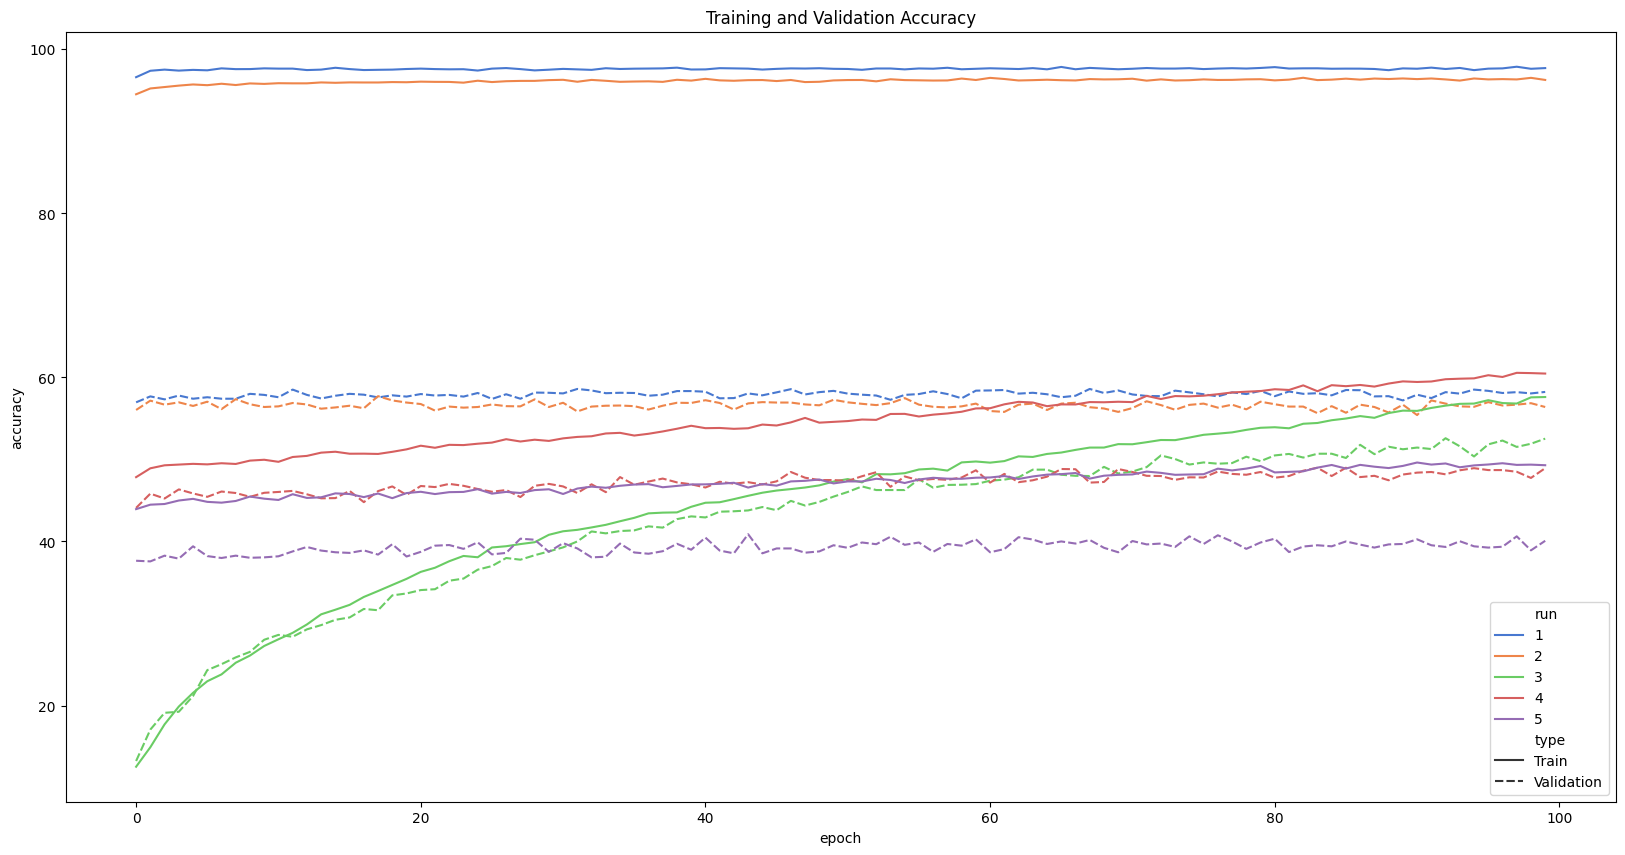

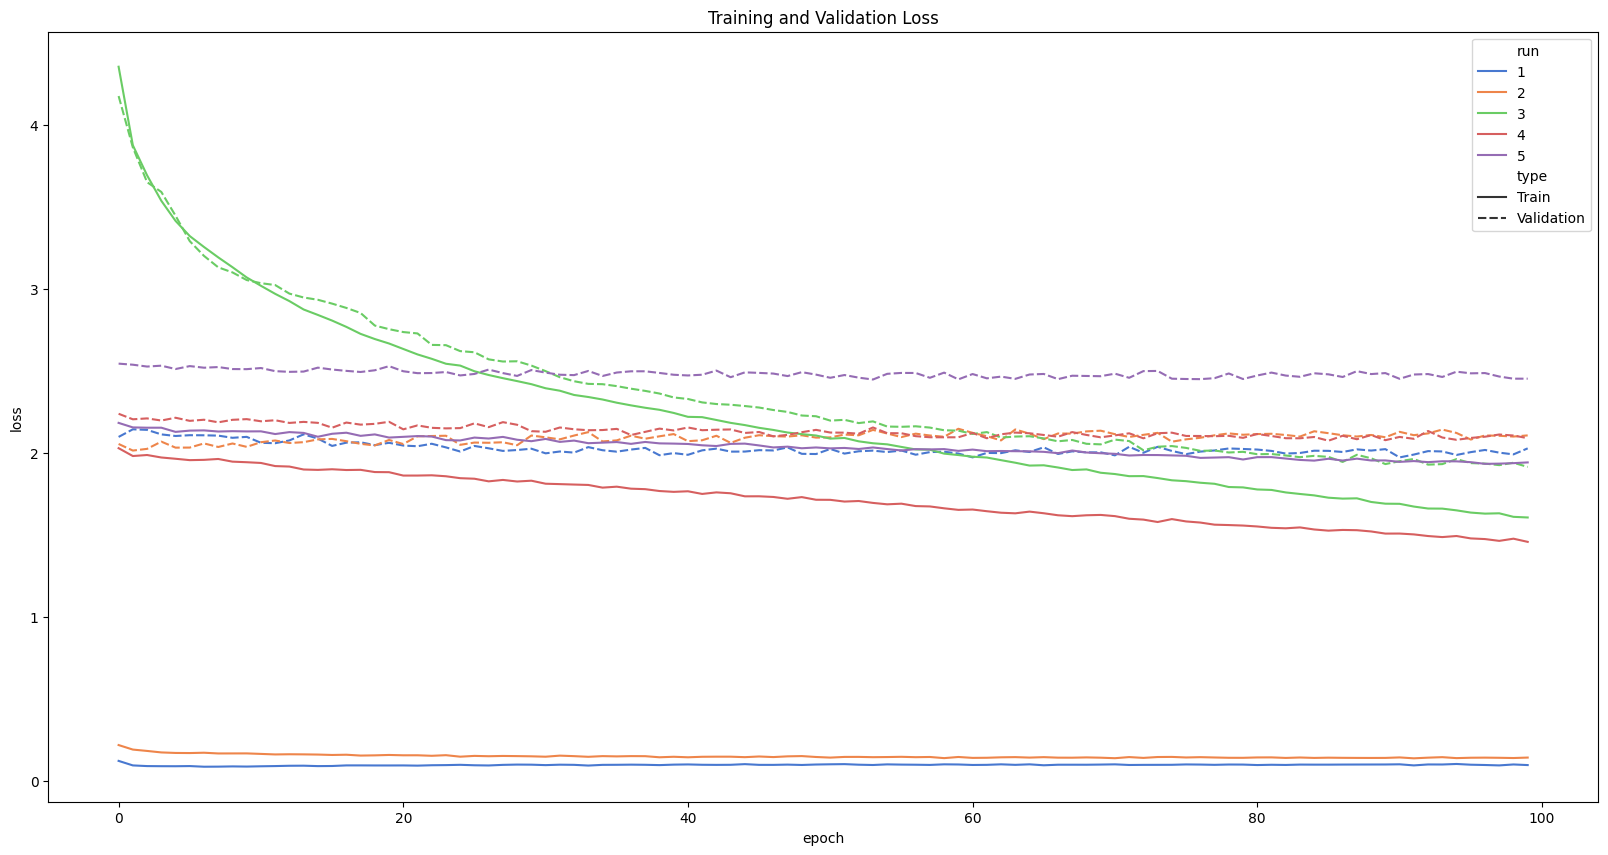

In [30]:
import seaborn as sns

# plot training and validation accuracy
plt.figure(figsize=(20, 10))
sns.lineplot(data=df, x='epoch', y='accuracy', hue='run', style='type', palette='muted')
plt.title('Training and Validation Accuracy')

# plot training and validation loss
plt.figure(figsize=(20, 10))
sns.lineplot(data=df, x='epoch', y='loss', hue='run', style='type', palette='muted')
plt.title('Training and Validation Loss')
